In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

sheet = pd.read_excel('data_input_auto/山东柴油裂解差Non-trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['山东柴油裂解差Non-Trend/F0.2'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

In [3]:
try:
    file_path1 = os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent原油价格_合并数据.xlsx")
    if not os.path.exists(file_path1):
        os.makedirs(file_path1)
except:
    file_path1 = os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent原油价格_合并数据.xlsx") 
    if not os.path.exists(file_path1):
        os.makedirs(file_path1)

sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['布伦特原油现货价格'])
sheet1 = sheet1.dropna()
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.head()

,Date,Brent原油期货价格预测
20,2025-03-17,71.13
19,2025-03-18,71.44
18,2025-03-19,71.31
17,2025-03-20,71.06
16,2025-03-21,70.36


In [4]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', 'Brent原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['Brent原油期货价格'] = sheet_daily['ICE Europe Brent Crude M1'].fillna(sheet_daily['Brent原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['Brent原油期货价格预测'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [5]:
sheet.columns

Index(['山东柴油裂解差Non-Trend/F0.2', 'ICE Europe Brent Crude M1',
       '柴油：社会库存：中国（周）：大样本1周环差', '螺纹期货价格20日环比', 'Brent原油期货价格'],
      dtype='object')

In [35]:
fill_methods = {
    '柴油：社会库存：中国（周）：大样本1周环差': 'interpolate', 
    '螺纹期货价格20日环比': 'interpolate', 
    'Brent原油期货价格': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)

#sheet.loc[:last_day, '山东柴油裂解差Non-Trend/F0.2'] = sheet.loc[:last_day, '山东柴油裂解差Non-Trend/F0.2'].interpolate(method='linear')

# 计算 Brent原油期货价格 30日环比
sheet['Brent原油期货价格30日环比'] = (sheet['Brent原油期货价格'] - sheet['Brent原油期货价格'].shift(30)) / sheet['Brent原油期货价格'].shift(30)
sheet['柴油：社会库存：中国（周）：大样本1周环差_提前20天'] = sheet['柴油：社会库存：中国（周）：大样本1周环差'].shift(20)
sheet['螺纹期货价格20日环比_提前40天'] = sheet['螺纹期货价格20日环比'].shift(40)

sheet['Brent原油期货价格30日环比_逆序'] = reverse_column(sheet, 'Brent原油期货价格30日环比')

################################# 数据筛选  #################################
# 重置索引 确保 `Date` 为 datetime 类型
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['山东柴油裂解差Non-Trend/F0.2'].notna())
]


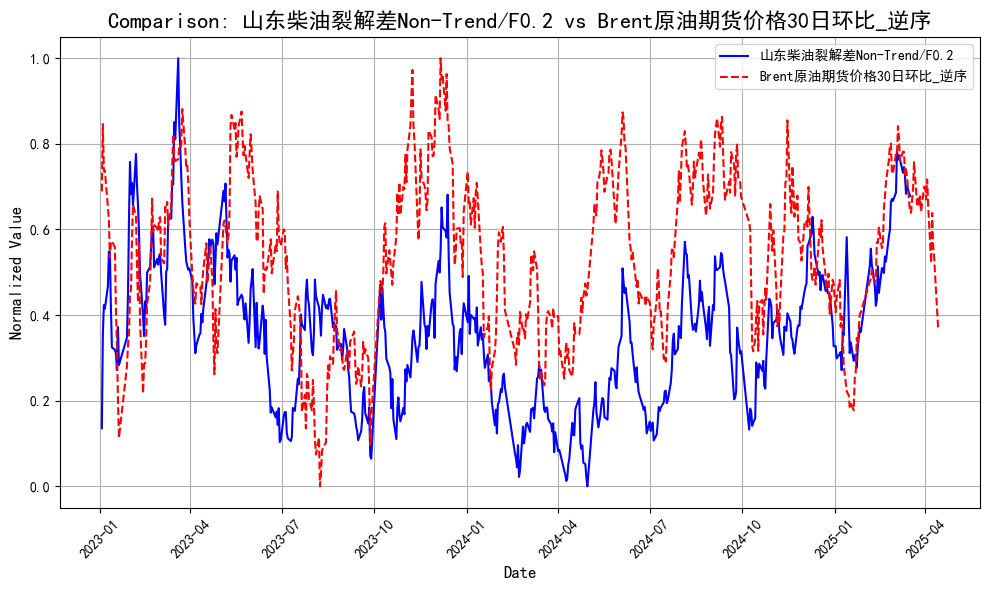

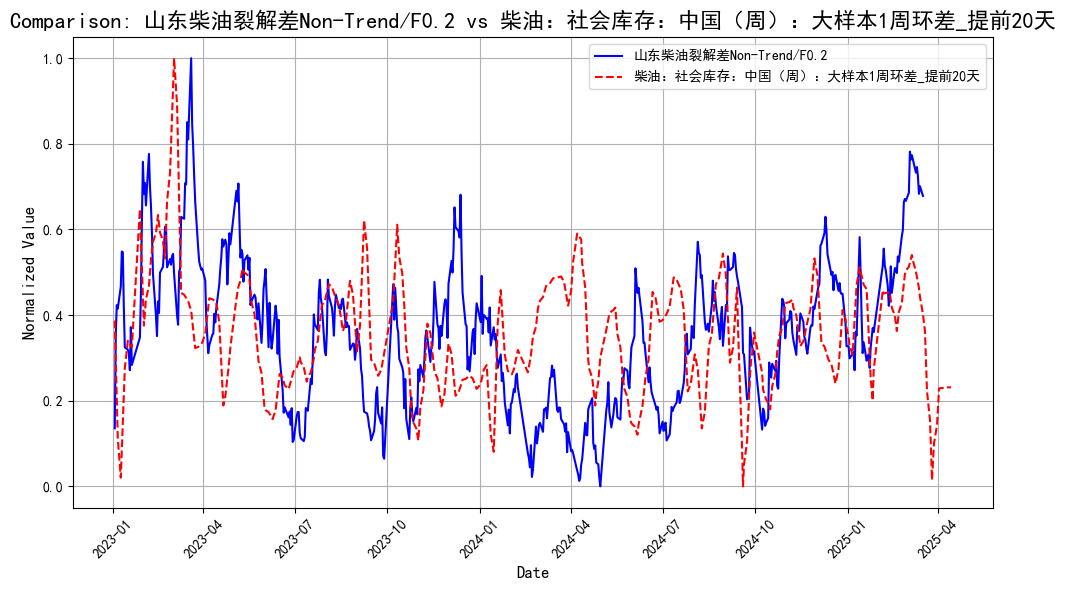

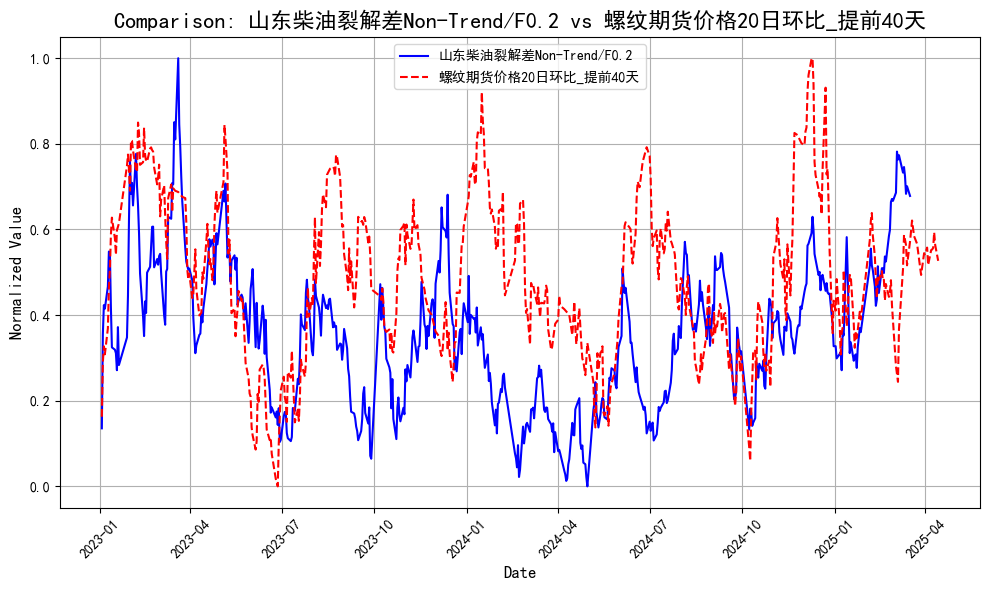

In [36]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='山东柴油裂解差Non-Trend/F0.2', 
    compare_cols=[
        'Brent原油期货价格30日环比_逆序',
        '柴油：社会库存：中国（周）：大样本1周环差_提前20天',
        '螺纹期货价格20日环比_提前40天'
        ]
)

In [37]:
# 测试 'Brent原油期货价格30日环比_逆序' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性
correlation_brent = sheet_daily['Brent原油期货价格30日环比_逆序'].corr(sheet_daily['山东柴油裂解差Non-Trend/F0.2'])
print(f"'Brent原油期货价格30日环比_逆序' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性: {correlation_brent}")

# 测试 '柴油：社会库存：中国（周）：大样本1周环差_提前20天' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性
correlation_diesel = sheet_daily['柴油：社会库存：中国（周）：大样本1周环差_提前20天'].corr(sheet_daily['山东柴油裂解差Non-Trend/F0.2'])
print(f"'柴油：社会库存：中国（周）：大样本1周环差_提前20天' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性: {correlation_diesel}")

# 测试 '螺纹期货价格20日环比_提前40天' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性
correlation_rebar = sheet_daily['螺纹期货价格20日环比_提前40天'].corr(sheet_daily['山东柴油裂解差Non-Trend/F0.2'])
print(f"'螺纹期货价格20日环比_提前40天' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性: {correlation_rebar}")


'Brent原油期货价格30日环比_逆序' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性: 0.42222251342989486
'柴油：社会库存：中国（周）：大样本1周环差_提前20天' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性: 0.1617895207210905
'螺纹期货价格20日环比_提前40天' 和 '山东柴油裂解差Non-Trend/F0.2' 的相关性: 0.30227208250275295


In [38]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'Brent原油期货价格30日环比_逆序',
        '柴油：社会库存：中国（周）：大样本1周环差_提前20天',
        '螺纹期货价格20日环比_提前40天'
]

predict_column = '山东柴油裂解差Non-Trend/F0.2'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 85)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,
    'max_depth': 5, 
    'min_child_weight': 5, 
    'subsample': 0.9, 
    'colsample_bytree': 1.0, 
    'gamma': 0, 
    'reg_alpha': 0, 
    'reg_lambda': 3,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=50,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=1000 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:407.52414	train-rmse:182.87784
[1000]	eval-rmse:298.22862	train-rmse:72.77808
[2000]	eval-rmse:292.91847	train-rmse:51.81712
[3000]	eval-rmse:291.53970	train-rmse:38.79993
[4000]	eval-rmse:292.00878	train-rmse:29.77201
[4999]	eval-rmse:293.88043	train-rmse:23.28919
训练集 MSE (DMatrix): 624.7865, 训练集 R² (DMatrix): 0.984
测试集 MSE (DMatrix): 86365.7077, 测试集 R² (DMatrix): -6.2874


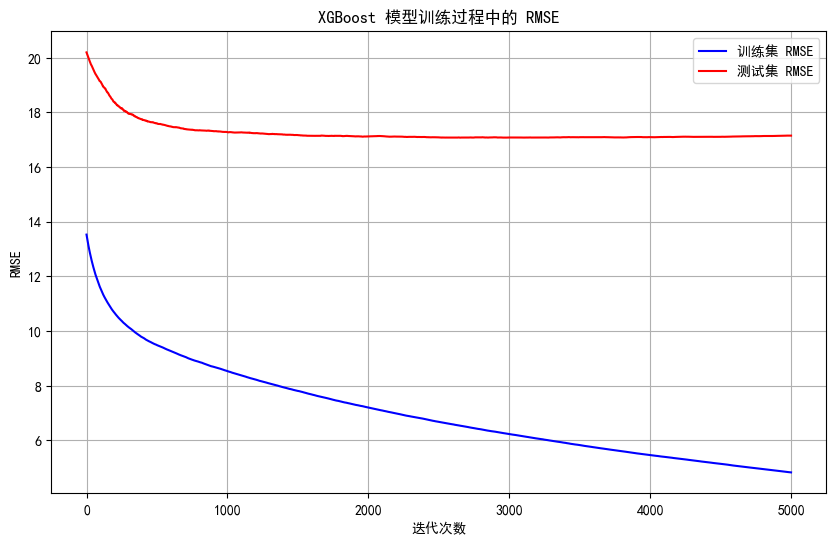

In [39]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=1000
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:190.98433
[1000]	train-rmse:74.14145
[2000]	train-rmse:53.28354
[3000]	train-rmse:40.40742
[4000]	train-rmse:31.31191
[4999]	train-rmse:24.62886
全部数据 MSE: 698.2697, 全部数据 R²: 0.9839


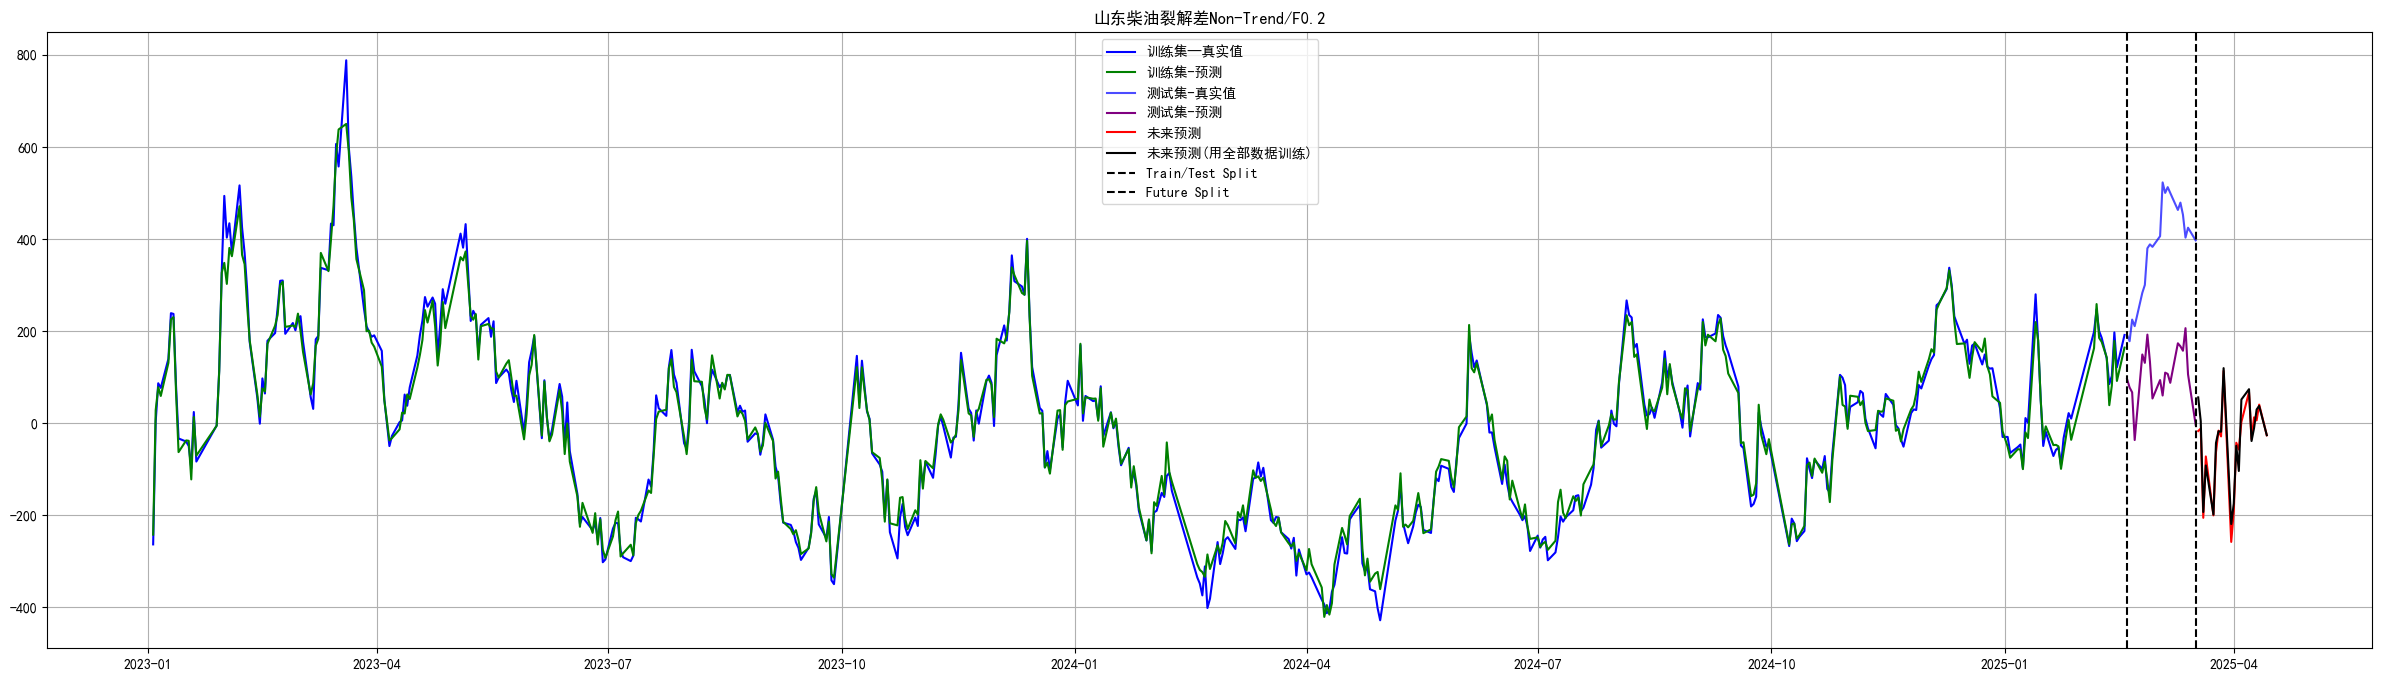

In [41]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('山东柴油裂解差Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()


---

In [49]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并历史真实值和预测值
merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
# 按日期排序 倒叙
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel 在 eta 文件夹里
merged_df_daily.to_excel('eta/山东柴油裂解差Non-Trend—F0.2_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/山东柴油裂解差Non-Trend-F0.2_月度数据.xlsx', index=False, float_format='%.4f')

In [ ]:
merged_df_daily

In [ ]:
merged_df_monthly

---

In [ ]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东柴油裂解差Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")